In [2]:
import os
!pip install kaggle

# Configure kaggle
os.chdir('/root/')
!mkdir .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Create data folder
os.chdir('/content/')
!rm -rf data    #remove any data directory already present
!mkdir data
os.chdir('data')
!pwd            # print working directory

# Download data
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Unzip data
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

kaggle.json
/content/data
 99% 282M/285M [00:01<00:00, 205MB/s]
100% 285M/285M [00:01<00:00, 199MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


LOADING AND VISUALIZING THE DATA
The image dataset downloaded from Kaggle is in ".csv" file format. Therefore, we need to load the "train.csv" file, and convert it to numpy array. The training images and labels are saved in "x_train" and "y_train" respectively.

In [3]:
import csv
import numpy

train_images = []
train_labels = []

categories_count = {}

with open('/content/data/train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


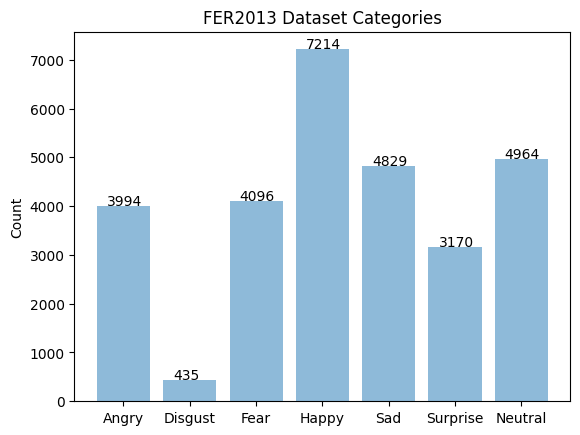

In [4]:
#visualize data

import matplotlib.pyplot as plt
%matplotlib inline

categories = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = numpy.arange(len(categories))

counts = []
for label in range(len(categories)):
    label_str = str(label)
    count = categories_count[label_str]
    counts.append(count)
    plt.text(label - 0.25, count + 15, str(count))

# Draw histogram
plt.bar(y_pos, counts, align='center', alpha=0.5)
plt.xticks(y_pos, categories)
plt.ylabel('Count')
plt.title('FER2013 Dataset Categories')

plt.show()

Label is: 0


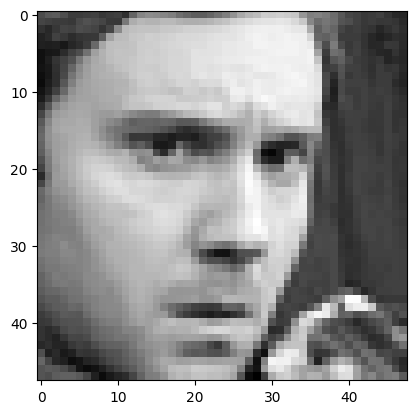

In [5]:
image = x_train[0]
label = y_train[0]

print('Label is: ' + str(label))
plt.imshow(image, cmap='gray')

Preprocessing Data


In [6]:
#create test and training sets
#80% training and 20% test
from sklearn.model_selection import train_test_split

# Split dataset into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

#normalize
x_train, x_test = x_train/ 255.0, x_test /255.0


x_train = x_train.reshape(len(x_train), 48, 48, 1)
x_test = x_test.reshape(len(x_test), 48, 48, 1)

print(x_train.shape)
print(x_test.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)


MODEL CREATION AND TRAINING

Model to be used: VGG NET
 - 2 Conv layers and a max pool layer [4 times]
 - 3 FUlly Connected dense layers
 - Softmax Classification Layer


In [7]:
#imported all necessary layers, activation functions etc
import tensorflow as tf

print('Tensorflow version: {}'.format(tf.__version__))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import Model, Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#This is done by Haroon

Tensorflow version: 2.15.0


In [8]:
cnn_model = Sequential()

# 1st convolution layer
cnn_model.add(Conv2D(64, input_shape=(48, 48, 1), kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))


# 2nd convolution layer
cnn_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))


# 3rd convolution layer
cnn_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

# 4th convolution layer
cnn_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

# Fully connected layer
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))

cnn_model.add(Dense(256, activation='relu'))

cnn_model.add(Dense(64, activation='relu'))

cnn_model.add(Dense(7, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.001)
cnn_model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Summary the model
cnn_model.summary()
#create the model following this setup @haroon

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                        

In [9]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

# Train the model
history = cnn_model.fit(x_train,
                        y_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
359/359 [==============================] - 35s 49ms/step - loss: 1.5741 - accuracy: 0.3773 - val_loss: 1.8126 - val_accuracy: 0.2072 - lr: 0.0010
Epoch 2/100
359/359 [==============================] - 15s 41ms/step - loss: 1.2534 - accuracy: 0.5248 - val_loss: 1.3043 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 3/100
359/359 [==============================] - 15s 42ms/step - loss: 1.1251 - accuracy: 0.5767 - val_loss: 1.1572 - val_accuracy: 0.5747 - lr: 0.0010
Epoch 4/100
359/359 [==============================] - 15s 41ms/step - loss: 1.0428 - accuracy: 0.6060 - val_loss: 1.2079 - val_accuracy: 0.5545 - lr: 0.0010
Epoch 5/100
359/359 [==============================] - 15s 41ms/step - loss: 0.9577 - accuracy: 0.6423 - val_loss: 1.1753 - val_accuracy: 0.5679 - lr: 0.0010
Epoch 6/100
359/359 [==============================] - 15s 42ms/step - loss: 0.8962 - accuracy: 0.6658 - val_loss: 1.0871 - val_accuracy: 0.6082 - lr: 0.0010
Epoch 7/100
359/359 [==============================]

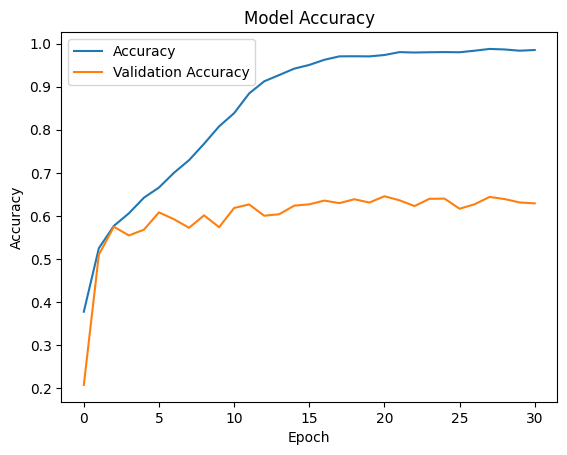

In [10]:
# Show accuracy diagram
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

WE CAN SEE THAT THE TRAINING ACCURACY >>>>> VALIDATION ACCURACY WHICH SUGGESTS OVERFITTIN AND NOW WE WILL TRY OT FIX THAT

FIRST TRY TO APPLY DROP OUT LAYERS

In [11]:
cnn_model2 = Sequential()

# 1st convolution layer
cnn_model2.add(Conv2D(64, input_shape=(48, 48, 1), kernel_size=(3, 3), activation='relu'))
cnn_model2.add(BatchNormalization())
cnn_model2.add(Conv2D(64, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model2.add(BatchNormalization())
cnn_model2.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model2.add(Dropout(0.3))

# 2nd convolution layer
cnn_model2.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model2.add(BatchNormalization())
cnn_model2.add(Conv2D(128, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model2.add(BatchNormalization())
cnn_model2.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model2.add(Dropout(0.3))

# 3rd convolution layer
cnn_model2.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model2.add(BatchNormalization())
cnn_model2.add(Conv2D(256, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model2.add(BatchNormalization())
cnn_model2.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model2.add(Dropout(0.3))

# 4th convolution layer
cnn_model2.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model2.add(BatchNormalization())
cnn_model2.add(Conv2D(512, padding='same', kernel_size=(3, 3), activation='relu'))
cnn_model2.add(BatchNormalization())
cnn_model2.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
cnn_model2.add(Dropout(0.3))

# Fully connected layer
cnn_model2.add(Flatten())
cnn_model2.add(Dense(512, activation='relu'))
cnn_model2.add(Dropout(0.3))
cnn_model2.add(Dense(256, activation='relu'))
cnn_model2.add(Dropout(0.3))
cnn_model2.add(Dense(64, activation='relu'))
cnn_model2.add(Dropout(0.3))

cnn_model2.add(Dense(7, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.001)
cnn_model2.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Summary the model
cnn_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_8 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_9 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                      

In [12]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)

# Train the model
history = cnn_model.fit(x_train,
                        y_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
359/359 [==============================] - 16s 44ms/step - loss: 0.0345 - accuracy: 0.9872 - val_loss: 2.4594 - val_accuracy: 0.6498 - lr: 5.9049e-04
Epoch 2/100
359/359 [==============================] - 16s 44ms/step - loss: 0.0299 - accuracy: 0.9893 - val_loss: 2.3898 - val_accuracy: 0.6423 - lr: 5.9049e-04
Epoch 3/100
359/359 [==============================] - 16s 44ms/step - loss: 0.0336 - accuracy: 0.9875 - val_loss: 2.5060 - val_accuracy: 0.6224 - lr: 5.9049e-04
Epoch 4/100
359/359 [==============================] - 15s 43ms/step - loss: 0.0390 - accuracy: 0.9862 - val_loss: 2.4634 - val_accuracy: 0.6174 - lr: 5.9049e-04
Epoch 5/100
359/359 [==============================] - 15s 42ms/step - loss: 0.0311 - accuracy: 0.9892 - val_loss: 2.4051 - val_accuracy: 0.6371 - lr: 5.9049e-04
Epoch 6/100
359/359 [==============================] - 15s 42ms/step - loss: 0.0302 - accuracy: 0.9897 - val_loss: 2.4470 - val_accuracy: 0.6296 - lr: 5.9049e-04
Epoch 7/100
359/359 [=======

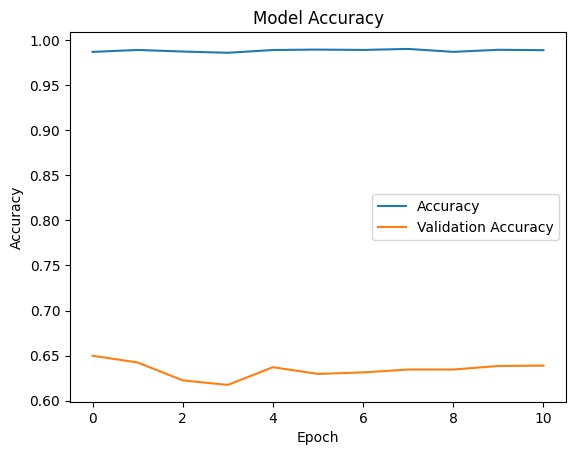

In [13]:
# Show accuracy diagram
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

Next, we will improve our model by generating hard data. Specifically, instead of training the model over and over again, we will select the images which are incorrectly labelled by the model, and train the model on these specific images. Therefore, let's use our model to make predictions first, and put the incorrect ones into the array of hard data for further training.


In [14]:
# Generate hard data
hard_images = []
hard_labels = []

# Make predictions
predictions = cnn_model.predict(x_test)
for i, v in enumerate(predictions):
    y_predict = numpy.argmax(v)
    y_real = y_train[i]
    if y_predict != y_real:
        # If predict incorrectly, append to array
        image = x_train[i]
        hard_image = image.reshape(1, 48, 48, 1)
        hard_images.append(image)
        hard_labels.append(y_real)

x_hard = numpy.array(hard_images)
y_hard = numpy.array(hard_labels)

print(x_hard.shape)
print(y_hard.shape)

180/180 [==============================] - 2s 9ms/step
(4715, 48, 48, 1)
(4715,)


In [15]:
# Train the model on hard data
x_hard_train, x_hard_test, y_hard_train, y_hard_test = train_test_split(x_hard, y_hard, test_size=0.2)
history = cnn_model.fit(x_hard_train,
                        y_hard_train,
                        batch_size=64,
                        epochs=100,
                        validation_data=(x_hard_test, y_hard_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
59/59 [==============================] - 6s 101ms/step - loss: 0.0243 - accuracy: 0.9918 - val_loss: 0.0616 - val_accuracy: 0.9830 - lr: 5.9049e-04
Epoch 2/100
59/59 [==============================] - 3s 44ms/step - loss: 0.0077 - accuracy: 0.9981 - val_loss: 0.0182 - val_accuracy: 0.9958 - lr: 5.9049e-04
Epoch 3/100
59/59 [==============================] - 3s 45ms/step - loss: 0.0068 - accuracy: 0.9992 - val_loss: 0.0093 - val_accuracy: 0.9979 - lr: 5.9049e-04
Epoch 4/100
59/59 [==============================] - 3s 43ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0054 - val_accuracy: 0.9989 - lr: 5.9049e-04
Epoch 5/100
59/59 [==============================] - 3s 45ms/step - loss: 9.1676e-04 - accuracy: 0.9995 - val_loss: 0.0043 - val_accuracy: 0.9989 - lr: 5.9049e-04
Epoch 6/100
59/59 [==============================] - 2s 42ms/step - loss: 7.2587e-04 - accuracy: 0.9997 - val_loss: 0.0040 - val_accuracy: 0.9989 - lr: 5.9049e-04
Epoch 7/100
59/59 [==================

In [16]:
# Perform data augmentation
data_generator = ImageDataGenerator(featurewise_center=False,
                                    featurewise_std_normalization=False,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=.1,
                                    horizontal_flip=True)
flow = data_generator.flow(x_train,
                           y_train,
                           batch_size=64)

# Train the model again to balance out
history = cnn_model.fit(flow,
                        epochs=100,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/100
359/359 [==============================] - 21s 56ms/step - loss: 1.0320 - accuracy: 0.6405 - val_loss: 1.0164 - val_accuracy: 0.6414 - lr: 5.9049e-04
Epoch 2/100
359/359 [==============================] - 18s 51ms/step - loss: 0.8815 - accuracy: 0.6781 - val_loss: 0.9834 - val_accuracy: 0.6480 - lr: 5.9049e-04
Epoch 3/100
359/359 [==============================] - 17s 47ms/step - loss: 0.8372 - accuracy: 0.6972 - val_loss: 0.9853 - val_accuracy: 0.6595 - lr: 5.9049e-04
Epoch 4/100
359/359 [==============================] - 21s 58ms/step - loss: 0.7890 - accuracy: 0.7145 - val_loss: 0.9606 - val_accuracy: 0.6599 - lr: 5.9049e-04
Epoch 5/100
359/359 [==============================] - 18s 50ms/step - loss: 0.7662 - accuracy: 0.7213 - val_loss: 0.9898 - val_accuracy: 0.6583 - lr: 5.9049e-04
Epoch 6/100
359/359 [==============================] - 17s 47ms/step - loss: 0.7259 - accuracy: 0.7349 - val_loss: 1.0137 - val_accuracy: 0.6625 - lr: 5.9049e-04
Epoch 7/100
359/359 [=======

Finally, let's evaluate our model again after improvement. Previously, we have the validation accuracy at around 64%. Nevertheless, the validation accuracy has increased to around **68%**.

In [17]:
# Evaluate the model after improvement
_, score_after_improvement = cnn_model.evaluate(x_test, y_test)
print('Score after improvement: {}'.format(score_after_improvement))

180/180 [==============================] - 1s 8ms/step - loss: 1.1546 - accuracy: 0.6569
Score after improvement: 0.6569139957427979


Results (And confusion matrix if possible)

180/180 [==============================] - 1s 7ms/step


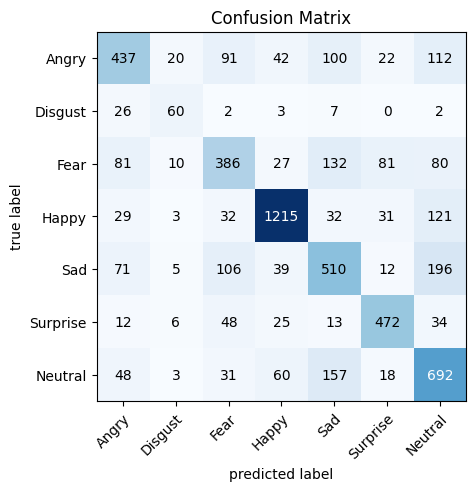

In [18]:

import matplotlib.pyplot as plt

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Make predictions
predictions = cnn_model.predict(x_test)
y_predict = numpy.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)

# Display confusion matrix
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, class_names=class_names)
plt.title('Confusion Matrix')
plt.show()

Testing on Local Images

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
from tensorflow.keras.preprocessing import image

def predict_facial_expression(image_path):
    """Predict facial expression for image"""
    # Open image
    rgb_image = image.load_img(path=image_path,
                            color_mode='grayscale',
                            target_size=(48, 48))
    # Convert to array
    rgb_array = image.img_to_array(rgb_image)
    rgb_array = numpy.expand_dims(rgb_array, axis=0)

    # Show image
    rgb_display = numpy.array(rgb_array, 'float32')
    rgb_display = rgb_display.reshape([48, 48]);
    plt.imshow(rgb_display, cmap='gray')
    plt.show()

    # Make predictions
    rgb_array = rgb_array / 255.0
    prediction = cnn_model.predict(rgb_array)

    # Draw the histogram
    plt.bar(y_pos, prediction[0], align='center', alpha=0.5)
    plt.xticks(y_pos, categories)
    plt.ylabel('Percentage')
    plt.title('Facial Expression Prediction')
    plt.show()

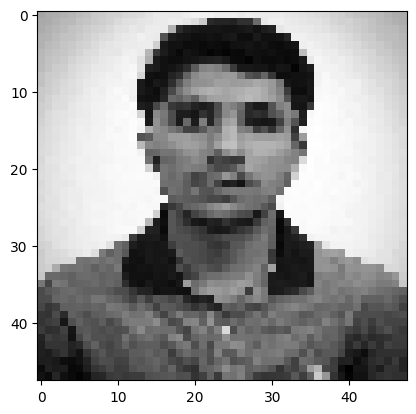

1/1 [==============================] - 0s 473ms/step


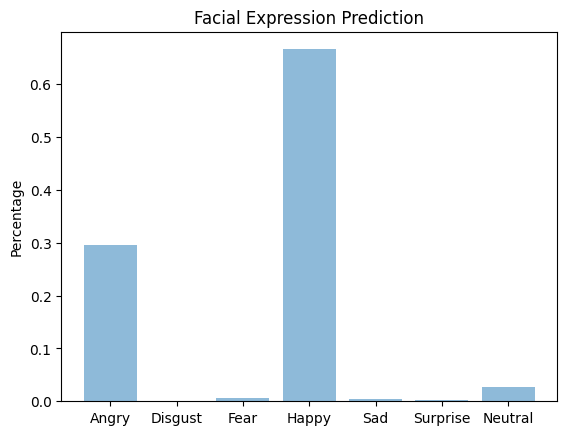

In [21]:
predict_facial_expression('/content/drive/MyDrive/face_recog/dataset/train/afra/afra1.jpg')

Collab Webcam and Live inference